# Application of k-means to weather data

In this example you will be calculating k-means cluster analysis on **wintertime (DJF) North American daily anomalous surface temperatures** from an atmosphere-only, time-slice experiment from the CESM2 model. The experiment is part of the Polar Amplification MIP (PAMIP), and the run used here has present day sea surface temperatures and pre-industrial sea ice conditions. It is composed of 100 1-year-long ensemble members. The daily data has had a 7-day low-pass filter applied, and has been weighted for this analysis. Daily anomalies (the data that you are clustering) are created by removing the daily ensemble mean from each member. 

NOTE: this data has no inter-annual frequencies! Each ensemble member is only a year long, and you are analyzing the winter season. So the variability in the data here represents synoptic to sub-seasonal time scales. 

The point here is to get a feel for the clustering analysis and its outputs, as well as interpreting the resulting clusters. **Choices are made as to the preferred number of clusters and the number of iterations.** 

The clusters will each be a map of anomalous surface temperatures over North America. When plotting it is useful to plot the anomalies as shading and the season mean climatology as contours.

If you want to play with this code (with this data, or your own), here are some things you can think about:
* Choose an appropriate number of clusters and other parameters required by your algorithm.
* Run k-means clustering on the data to output the cluster centroids themselves as well as the labels for each of your samples.
* Plot the different cluster centroids in a manageable, ingestible way.
* Summarize the cluster labels for each of your samples in a manageable, ingestible way. Feel free to discuss with me or the TA how you might do this.


### Load the modules

In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................
# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.cluster.vq import kmeans,vq
import scipy.io as sio
import xarray as xr
import numpy.ma as ma

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

if(IN_COLAB == True):
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !pip uninstall -y shapely
    !pip install shapely --no-binary shapely

    !pip install netcdf4 #Package for loading in netcdf4 files
    !pip install cmocean #Package with beautiful colormaps

import cartopy as ct
import cartopy.crs as ccrs
import cmocean as cmocean

mpl.rcParams['figure.dpi']= 100
CL = 0.
mapProj = ct.crs.PlateCarree(central_longitude = CL)

IN_COLAB = False


In [2]:
# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

env: PYTHONHASHSEED=99


### Functions

In [3]:

def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()
    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons) #fixes white line by adding point#data,lons#ct.util.add_cyclic_point(data, coord=lons) #fixes white line by adding point

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    
    if(np.size(contourMap) !=0 ):
        contourMap_cyc, __ = add_cyclic_point(contourMap, coord=lons) #fixes white line by adding point
        ax.contour(lons_cyc,lats,contourMap_cyc,contourVals, transform=data_crs, colors='fuchsia')
    
    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent)
        cb.ax.tick_params(labelsize=6) 
    else:
        cb = None

    image.set_clim(vmin,vmax)
    
    return cb, image  

def add_cyclic_point(data, coord=None, axis=-1):

    # had issues with cartopy finding utils so copied for myself
    
    if coord is not None:
        if coord.ndim != 1:
            raise ValueError('The coordinate must be 1-dimensional.')
        if len(coord) != data.shape[axis]:
            raise ValueError('The length of the coordinate does not match '
                             'the size of the corresponding dimension of '
                             'the data array: len(coord) = {}, '
                             'data.shape[{}] = {}.'.format(
                                 len(coord), axis, data.shape[axis]))
        delta_coord = np.diff(coord)
        if not np.allclose(delta_coord, delta_coord[0]):
            raise ValueError('The coordinate must be equally spaced.')
        new_coord = ma.concatenate((coord, coord[-1:] + delta_coord[0]))
    slicer = [slice(None)] * data.ndim
    try:
        slicer[axis] = slice(0, 1)
    except IndexError:
        raise ValueError('The specified axis does not correspond to an '
                         'array dimension.')
    new_data = ma.concatenate((data, data[tuple(slicer)]), axis=axis)
    if coord is None:
        return_value = new_data
    else:
        return_value = new_data, new_coord
    return return_value


### Load in the data

_Data Description:_

20 years of wintertime (December-February) North American daily anomalous surface temperature as simu- lated by an atmosphere-only, time-slice experiment with the NCAR CESM2 model. The experiment is part of the Polar Amplification MIP (PAMIP), and the run used here has present day sea surface temperatures and pre-industrial sea ice conditions. It is composed of 100 1-year-long ensemble members (but you will only analyze 20 years). The daily data has had a 7-day low-pass filter applied, and has been weighted for this analysis. Daily anomalies (the data that you are clustering) are created by removing the daily ensemble mean from each member.

In [4]:
filename = 'tas_DJFdays_PAMIP_CESM2_NorthAmerica.nc'

if(IN_COLAB):
    !wget https://github.com/eabarnes1010/ats655-coursematerial/raw/master/jupyter_notebooks/data/tas_DJFdays_PAMIP_CESM2_NorthAmerica.nc
    da = xr.open_dataset(filename) # open the data
else:
    da = xr.open_dataset('data/' + filename)

data = da['__xarray_dataarray_variable__'].values
lat = da['latitude']
lon = da['longitude']

da.head()

<xarray.Dataset>
Dimensions:                        (latitude: 5, longitude: 5, time: 5)
Coordinates:
  * latitude                       (latitude) float64 1.0 3.0 5.0 7.0 9.0
  * longitude                      (longitude) float64 200.0 202.0 ... 208.0
  * time                           (time) int64 1 2 3 4 5
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float64 0.05254 ... 0.2079

### K-means
The code below is the k-means algorithm:

`clusters, dist = kmeans(data, K, iter=50)`

`classes, _ = vq(data,clusters)`

The first line outputs the clusters (or nodes, centroids; *matrix*) and the sum distance (also called quantization error; *integer*), and uses as input the dataset, the chosen number of clusters, and the number of iterations you want. The iterations represent the number of times the algorithm resets the initial random placement of the clusters (or centroids) and restarts the unsupervised learning. The output is the set of centroids from all of these iterations that has the minimum sum squared distances. 

The second line goes outputs the assigned cluster for each day (*vector*).

You are going to run the k-means algorithm for three different numbers of clusters (ex. 4, 6, and 9 clusters) and compare the outputs. **Note that this algorithm does take some time to run, especially for large numbers of iterations!**

### part (a,b) - choose parameters and run clustering algorithm

In [13]:
# Pick the number of clusters you want to test:
numclust = [6,]
for K in numclust:
 #  clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations) 
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), K, iter=20)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)

    # output each time as a new .mat file
    filen = 'KMoutput_K' + str(K) + 'NAMtas.mat'
#     sio.savemat(filen,{'quant_error': dist, 'classes': classes, 'centroids': clusters})
    
print('clusters shape = ' + str(clusters.shape))
print('classes shape = ' + str(classes.shape))    

clusters shape = (6, 2745)
classes shape = (1800,)


### part (c) - plot the clusters

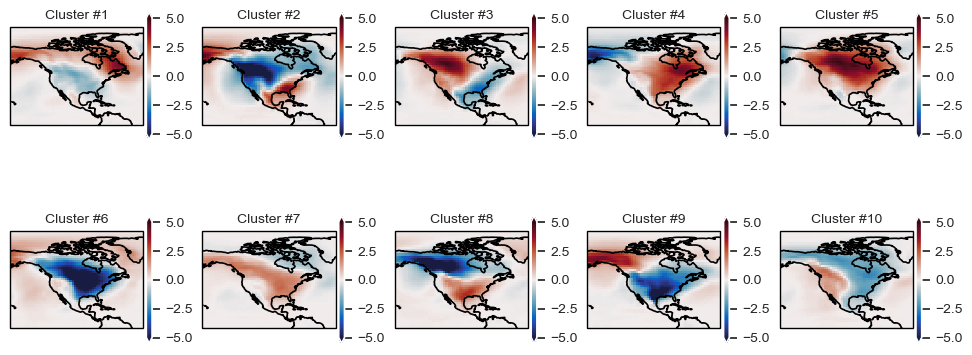

In [12]:
maxVal = 5.
titleSize = 10
cmap = cmocean.cm.balance
fastBool = True

extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

plt.figure(figsize=(8*1.5,5*1.5*.66))

for cluster in np.arange(0,numclust[0]):
    ax = plt.subplot(2,np.ceil(K/2.),cluster+1,projection=mapProj)
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    cb, image = drawOnGlobe(ax, xplot, np.squeeze(lat), np.squeeze(lon), cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
    ax.set_extent(extent)
    cb.set_label('', fontsize=titleSize)
    cb.ax.tick_params(labelsize=titleSize) 
    plt.title('Cluster #' + str(cluster+1), fontsize=titleSize)

plt.show()

### part (d) - summarize cluster labels

For this I will plot a frequency diagram of how often each cluster happens.

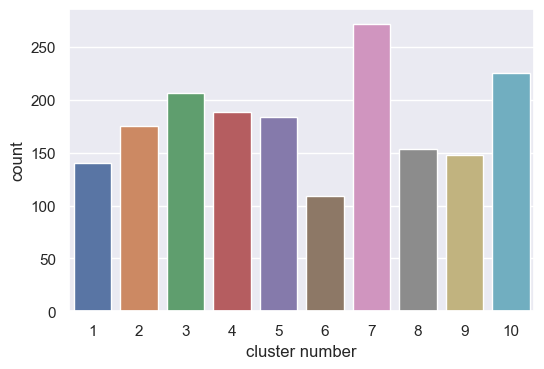

In [11]:
da = pd.DataFrame(data={'class':classes+1})

sns.set(style="darkgrid")
ax = sns.countplot(data=da,x='class')
plt.xlabel('cluster number')
plt.show()

Cluster #6 appears to be the most frequent and describes a warm west, and cold east. The least frequent cluster is #3 which describes a cold Canadian region and warm southern U.S. 